# Draft 1 - Figure 4

__Brainstormed Description:__  

_Maps Regional (IPCC) and Spatial (5x5deg) of a. obs. unc. spread, b. Model ICV spread, and c. their ratio. (methods for the spread values are introduced in Figure 3)._

So I will need to work with both the IPCC regional and 5x5 degree spatial data. This will be similar to figure 1.

### Load functions and packages

In [1]:
import glob
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import regionmask

import cartopy.crs as ccrs

import copy

%matplotlib inline

In [2]:
import regionmask

import cartopy.crs as ccrs
import matplotlib.patheffects as pe

In [3]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap

In [4]:
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)


def to_png(file, filename, loc='/glade/u/home/jonahshaw/figures/',dpi=200,ext='png',**kwargs):
    '''
    Simple function for one-line saving.
    Saves to "/glade/u/home/jonahshaw/figures" by default
    '''
    output_dir = loc
    #ext = 'png'
    full_path = '%s%s.%s' % (output_dir,filename,ext)

    if not os.path.exists(output_dir + filename):
        file.savefig(full_path,format=ext, dpi=dpi,**kwargs)
#         file.clf()
        
    else:
        print('File already exists, rename or delete.')

In [5]:
def convert_ipcc_to_latlon(
    data: xr.DataArray,
    mask: regionmask.Regions = regionmask.defined_regions.ar6.all,
):

    mean_data   = data.sel(metric='mean')
    strict_data = data.sel(metric='strict')
    delay_data  = data.sel(metric='delay')
    delay_mask  = data.sel(metric='delay_mask')

    unc_mask = mask.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

    # CESM1-GISTEMP 5x5
    _mean_mask   = unc_mask.copy()
    _strict_mask = unc_mask.copy()
    _delay_data_mask  = unc_mask.copy()
    _delay_mask_mask  = unc_mask.copy()

    del unc_mask

    offset = -1000 # Need an offset or it may confuse regions with the delays (delays are on [0,40] similar to the region indices)
    for i in mask.numbers:
        
        _mean_mask   = xr.where(_mean_mask==i,mean_data.sel(RegionIndex=i)+offset,_mean_mask)
        _strict_mask = xr.where(_strict_mask==i,strict_data.sel(RegionIndex=i)+offset,_strict_mask)
        _delay_data_mask  = xr.where(_delay_data_mask==i,delay_data.sel(RegionIndex=i)+offset,_delay_data_mask)
        _delay_mask_mask  = xr.where(_delay_mask_mask==i,delay_mask.sel(RegionIndex=i)+offset,_delay_mask_mask)

    regional_masked_da = xr.concat([_mean_mask,_strict_mask,_delay_data_mask,_delay_mask_mask],dim='metric')-offset
    
    return regional_masked_da

## Load computed ToE data

In [6]:
toe_savedir = "/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/ToE_output"

spatial_masked_da = xr.open_dataarray(f"{toe_savedir}/ToE_delay.5x5.nc").drop_sel(obs="DCENT_unfilled")
regional_masked_da = xr.open_dataarray(f"{toe_savedir}/ToE_delay.IPCCRegions.nc").drop_sel(obs="DCENT_unfilled")

Need to convert the IPCC Region Indexing to lat-lon coordinates in order to plot spatially.

In [7]:
# Apply the land mask here.
mask = regionmask.defined_regions.ar6.land
regional_latlon_da = convert_ipcc_to_latlon(
    regional_masked_da,
    mask=mask,
)
landmask = ~np.isnan(mask.mask(regional_latlon_da["lon"], regional_latlon_da["lat"],))

In [8]:
# Make a better land mask for the spatial 5x5 deg. regions
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask_3D_frac_approx(
    spatial_masked_da
).squeeze()
spatial_landmask = land>0.5

In [9]:
# Mask the spatial ToE data with DCENT availability
spatial_landmasked_da = spatial_masked_da.where(landmask)

#### Plot the spread over models vs. over the observational products.

Compute the spread values:

- The obs. spread is the average separation between 1 model with both obs. products
- The model spread is the spread for all models with one observational product, averaged for the two obs. products

If I want to remove the effect of the Mckinnon OBS-LE, I can just do this:  

_regional_masked_da.isel(model=slice(None,4))_  

_spatial_masked_da.isel(model=slice(None,4))_

In [10]:
count_threshold = 6 # 8

regional_toe_mean   = regional_latlon_da.sel(metric='mean')
regional_toe_strict = regional_latlon_da.sel(metric='strict')

# skipna = False when operating over the 'obs' dimension because it only has a single value!
region_mean_obs_spread = (regional_toe_mean.max(dim='obs',skipna=False) - regional_toe_mean.min(dim='obs',skipna=False)).mean(dim='model') # Average spread between GISTEMP and HadCRUT
region_mean_mod_spread = (regional_toe_mean.max(dim='model') - regional_toe_mean.min(dim='model')).mean(dim='obs',skipna=True)

region_strict_obs_spread = (regional_toe_strict.max(dim='obs',skipna=False) - regional_toe_strict.min(dim='obs',skipna=False)).mean(dim='model')
region_strict_mod_spread = (regional_toe_strict.max(dim='model') - regional_toe_strict.min(dim='model')).mean(dim='obs',skipna=True)

# Mask if either obs or model spread is missing.
region_mean_spread = regional_toe_mean.max(dim=["model", "obs"]) - regional_toe_mean.min(dim=["model", "obs"])
region_mean_spread = region_mean_spread.where(~np.isnan(region_mean_obs_spread) & ~np.isnan(region_mean_mod_spread))
region_strict_spread = regional_toe_strict.max(dim=["model", "obs"]) - regional_toe_strict.min(dim=["model", "obs"])
region_strict_spread = region_strict_spread.where(~np.isnan(region_strict_obs_spread) & ~np.isnan(region_strict_mod_spread))
# # Require 8 models to have a value or set to nan
# region_mean_spread = region_mean_spread.where((~np.isnan(regional_toe_mean)).sum(dim=["model", "obs"]) >= count_threshold)
# region_strict_spread = region_strict_spread.where((~np.isnan(regional_toe_strict)).sum(dim=["model", "obs"]) >= count_threshold)

In [11]:
# count_threshold = 6 # 8

# spatial_toe_mean = spatial_masked_da.sel(metric='mean')
# spatial_toe_strict = spatial_masked_da.sel(metric='strict')

# spatial_mean_obs_spread = (spatial_toe_mean.max(dim='obs',skipna=False) - spatial_toe_mean.min(dim='obs',skipna=False)).mean(dim='model') # Average spread between GISTEMP and HadCRUT
# spatial_mean_mod_spread = (spatial_toe_mean.max(dim='model') - spatial_toe_mean.min(dim='model')).mean(dim='obs',skipna=True)

# spatial_strict_obs_spread = (spatial_toe_strict.max(dim='obs',skipna=False) - spatial_toe_strict.min(dim='obs',skipna=False)).mean(dim='model')
# spatial_strict_mod_spread = (spatial_toe_strict.max(dim='model') - spatial_toe_strict.min(dim='model')).mean(dim='obs',skipna=True)

# spatial_mean_spread = spatial_toe_mean.max(dim=["model", "obs"]) - spatial_toe_mean.min(dim=["model", "obs"])
# spatial_mean_spread = spatial_mean_spread.where(~np.isnan(spatial_mean_obs_spread) & ~np.isnan(spatial_mean_mod_spread))
# spatial_strict_spread = spatial_toe_strict.max(dim=["model", "obs"]) - spatial_toe_strict.min(dim=["model", "obs"])
# spatial_strict_spread = spatial_strict_spread.where(~np.isnan(spatial_strict_obs_spread) & ~np.isnan(spatial_strict_mod_spread))
# # Require 8 models to have a value or set to nan
# # spatial_mean_spread = spatial_mean_spread.where((~np.isnan(spatial_toe_mean)).sum(dim=["model", "obs"]) >= count_threshold)
# # spatial_strict_spread = spatial_strict_spread.where((~np.isnan(spatial_toe_strict)).sum(dim=["model", "obs"]) >= count_threshold)

In [12]:
spatial_toe_mean = spatial_masked_da.sel(metric='mean')
spatial_toe_strict = spatial_masked_da.sel(metric='strict')

spatial_mean_obs_spread = (spatial_toe_mean.max(dim='obs') - spatial_toe_mean.min(dim='obs')).mean(dim='model') # Average spread between GISTEMP and HadCRUT
spatial_mean_mod_spread = (spatial_toe_mean.max(dim='model') - spatial_toe_mean.min(dim='model')).mean(dim='obs')

spatial_strict_obs_spread = (spatial_toe_strict.max(dim='obs') - spatial_toe_strict.min(dim='obs')).mean(dim='model')
spatial_strict_mod_spread = (spatial_toe_strict.max(dim='model') - spatial_toe_strict.min(dim='model')).mean(dim='obs')

spatial_mean_spread = spatial_toe_mean.max(dim=["model", "obs"]) - spatial_toe_mean.min(dim=["model", "obs"])
spatial_mean_spread = spatial_mean_spread.where(~np.isnan(spatial_mean_obs_spread) & ~np.isnan(spatial_mean_mod_spread))
spatial_strict_spread = spatial_toe_strict.max(dim=["model", "obs"]) - spatial_toe_strict.min(dim=["model", "obs"])
spatial_strict_spread = spatial_strict_spread.where(~np.isnan(spatial_strict_obs_spread) & ~np.isnan(spatial_strict_mod_spread))

In [13]:
# Function for the regional figures.
def plot_regional_spread(obs_spread,model_spread,title=True):

    fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(21,6))
    axs = axs.flat

    cax1 = plt.axes([0.18, 0.22, 0.40, 0.03])
    cax2 = plt.axes([0.675, 0.22, 0.20, 0.03])

    ToE_cmap = copy.copy(mpl.cm.viridis)
    Toe_cmap = ListedColormap(sns.color_palette('viridis',n_colors=256))    
    
    delay_cmap = ListedColormap(sns.color_palette('vlag',n_colors=256))
    delay_cmap.set_over('darkred')
    delay_cmap.set_under('darkblue')
    
    spread_levels = np.linspace(0,20,5) # This should exclude zeros
    delay_levels  = np.linspace(-0.8,0.8,9)
    spread_ratio  = np.log10(obs_spread/model_spread)
    
    masks  = [obs_spread,model_spread,spread_ratio]
    titles = ['Obs Spread','Model Spread','Uncertainty Ratio (obs / model)']
    levels = [spread_levels,spread_levels,delay_levels] 
    cmaps = [Toe_cmap,Toe_cmap,delay_cmap]
    extend = ['max','max','both']

    plt.subplots_adjust(wspace=0.05)

    ims = [] 
    for _ax,_mask,_label,_levels,_cmap,_extend in zip(axs,masks,titles,levels,cmaps,extend):

        im = _ax.contourf(_mask.lon,_mask.lat,_mask, 60,
                          transform=ccrs.PlateCarree(),
                          levels=_levels,
                          cmap=_cmap,
                          extend=_extend,
                         )
        
        _ = _ax.contourf(_mask.lon,_mask.lat,np.isnan(_mask),
                         transform=ccrs.PlateCarree(),
                         levels=[0,0.5,1.5],
                         extend='max',
                         colors=['none','gray'],
                         hatches=[None,'\\\\',],
                        )    

        _ax.coastlines()
        _ax.set_global()
        _ax.set_title(_label,fontsize=16)

        ims.append(im)

    cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                         ticks=spread_levels,
                         cax=cax1,#label='Years',
                        )
    cbar1.set_label(label='Years',size=15,weight=None)

    cbar2 = fig.colorbar(ims[2],orientation='horizontal',
                         ticks=delay_levels,
                         cax=cax2,
                        )
    cbar2.set_label(label='$log_{10}(\delta_{obs} / \delta_{model}$)',size=15,weight=None)

    cbar1.ax.tick_params(labelsize=12) 
    cbar2.ax.tick_params(labelsize=12)

    fig.text(0.14, 0.68, "a.", fontsize=14)
    fig.text(0.40, 0.68, "b.", fontsize=14)
    fig.text(0.665, 0.68, "c.", fontsize=14)

    if title:
        fig.suptitle('Method Spread',fontsize=20,y=0.87)
    
    return fig

<>:63: SyntaxWarning: invalid escape sequence '\d'
<>:63: SyntaxWarning: invalid escape sequence '\d'
/glade/derecho/scratch/jonahshaw/tmp/ipykernel_63210/1055391854.py:63: SyntaxWarning: invalid escape sequence '\d'
  cbar2.set_label(label='$log_{10}(\delta_{obs} / \delta_{model}$)',size=15,weight=None)


In [14]:
# Function for the regional figures.
def plot_regional_spread2(
    total_spread,
    obs_spread,
    model_spread,
    title=True,
):

    fig,axs = sp_map(1,4,projection=ccrs.Robinson(),figsize=(25,6))
    axs = axs.flat

    cax1 = plt.axes([0.18, 0.22, 0.40, 0.03])
    cax2 = plt.axes([0.675, 0.22, 0.20, 0.03])

    ToE_cmap = copy.copy(mpl.cm.viridis)
    Toe_cmap = ListedColormap(sns.color_palette('viridis',n_colors=256))    
    
    delay_cmap = ListedColormap(sns.color_palette('vlag',n_colors=256))
    delay_cmap.set_over('darkred')
    delay_cmap.set_under('darkblue')
    
    spread_levels = np.linspace(0,25,5) # This should exclude zeros
    delay_levels  = np.linspace(-0.8,0.8,9)
    spread_ratio  = np.log10(obs_spread/model_spread)
    
    masks  = [total_spread, obs_spread, model_spread, spread_ratio]
    titles = ["Total Spread", 'Obs Spread','Model Spread','Uncertainty Ratio (obs / model)']
    levels = [spread_levels, spread_levels, spread_levels, delay_levels] 
    cmaps = [Toe_cmap, Toe_cmap, Toe_cmap, delay_cmap]
    extend = ["max", 'max', 'max', 'both']

    plt.subplots_adjust(wspace=0.05)

    ims = [] 
    for _ax,_mask,_label,_levels,_cmap,_extend in zip(axs,masks,titles,levels,cmaps,extend):

        im = _ax.contourf(_mask.lon,_mask.lat,_mask, 60,
                          transform=ccrs.PlateCarree(),
                          levels=_levels,
                          cmap=_cmap,
                          extend=_extend,
                         )
        
        _ = _ax.contourf(_mask.lon,_mask.lat,np.isnan(_mask),
                         transform=ccrs.PlateCarree(),
                         levels=[0,0.5,1.5],
                         extend='max',
                         colors=['none','gray'],
                         hatches=[None,'\\\\',],
                        )    

        _ax.coastlines()
        _ax.set_global()
        _ax.set_title(_label,fontsize=16)

        ims.append(im)

    cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                         ticks=spread_levels,
                         cax=cax1,#label='Years',
                        )
    cbar1.set_label(label='Years',size=15,weight=None)

    cbar2 = fig.colorbar(ims[3],orientation='horizontal',
                         ticks=delay_levels,
                         cax=cax2,
                        )
    cbar2.set_label(label='$log_{10}(\delta_{obs} / \delta_{model}$)',size=15,weight=None)

    cbar1.ax.tick_params(labelsize=12) 
    cbar2.ax.tick_params(labelsize=12)

    fig.text(0.14, 0.68, "a.", fontsize=14)
    fig.text(0.40, 0.68, "b.", fontsize=14)
    fig.text(0.665, 0.68, "c.", fontsize=14)

    if title:
        fig.suptitle('Method Spread',fontsize=20,y=0.87)
    
    return fig

<>:68: SyntaxWarning: invalid escape sequence '\d'
<>:68: SyntaxWarning: invalid escape sequence '\d'
/glade/derecho/scratch/jonahshaw/tmp/ipykernel_63210/2628194690.py:68: SyntaxWarning: invalid escape sequence '\d'
  cbar2.set_label(label='$log_{10}(\delta_{obs} / \delta_{model}$)',size=15,weight=None)


In [15]:
# Function for the regional figures.
def plot_regional_spread3(
    total_spread,
    obs_spread,
    model_spread,
    title=True,
):

    fig,axs = sp_map(1, 3, projection=ccrs.Robinson(), figsize=(21, 6))
    axs = axs.flat

    cax1 = plt.axes([0.275, 0.22, 0.50, 0.03])

    ToE_cmap = copy.copy(mpl.cm.viridis)
    Toe_cmap = ListedColormap(sns.color_palette('viridis',n_colors=256))    
        
    spread_levels = np.linspace(0,25,6) # This should exclude zeros
    
    masks  = [total_spread, obs_spread, model_spread]
    titles = ["Total Spread", 'Obs Spread', 'Model Spread']
    levels = [spread_levels, spread_levels, spread_levels] 
    cmaps = [Toe_cmap, Toe_cmap, Toe_cmap]
    extend = ["max", 'max', 'max']

    plt.subplots_adjust(wspace=0.05)

    ims = [] 
    for _ax,_mask,_label,_levels,_cmap,_extend in zip(axs,masks,titles,levels,cmaps,extend):

        im = _ax.contourf(_mask.lon,_mask.lat,_mask, 60,
                          transform=ccrs.PlateCarree(),
                          levels=_levels,
                          cmap=_cmap,
                          extend=_extend,
                         )
        
        _ = _ax.contourf(_mask.lon,_mask.lat,np.isnan(_mask),
                         transform=ccrs.PlateCarree(),
                         levels=[0,0.5,1.5],
                         extend='max',
                         colors=['none','gray'],
                         hatches=[None,'\\\\',],
                        )    

        _ax.coastlines()
        _ax.set_global()
        _ax.set_title(_label,fontsize=16)

        ims.append(im)

    cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                         ticks=spread_levels,
                         cax=cax1,#label='Years',
                        )
    cbar1.set_label(label='Years',size=15,weight=None)
    cbar1.ax.tick_params(labelsize=12) 

    fig.text(0.14, 0.68, "a.", fontsize=14)
    fig.text(0.40, 0.68, "b.", fontsize=14)
    fig.text(0.665, 0.68, "c.", fontsize=14)

    if title:
        fig.suptitle('Method Spread',fontsize=20,y=0.87)
    
    return fig

It works.

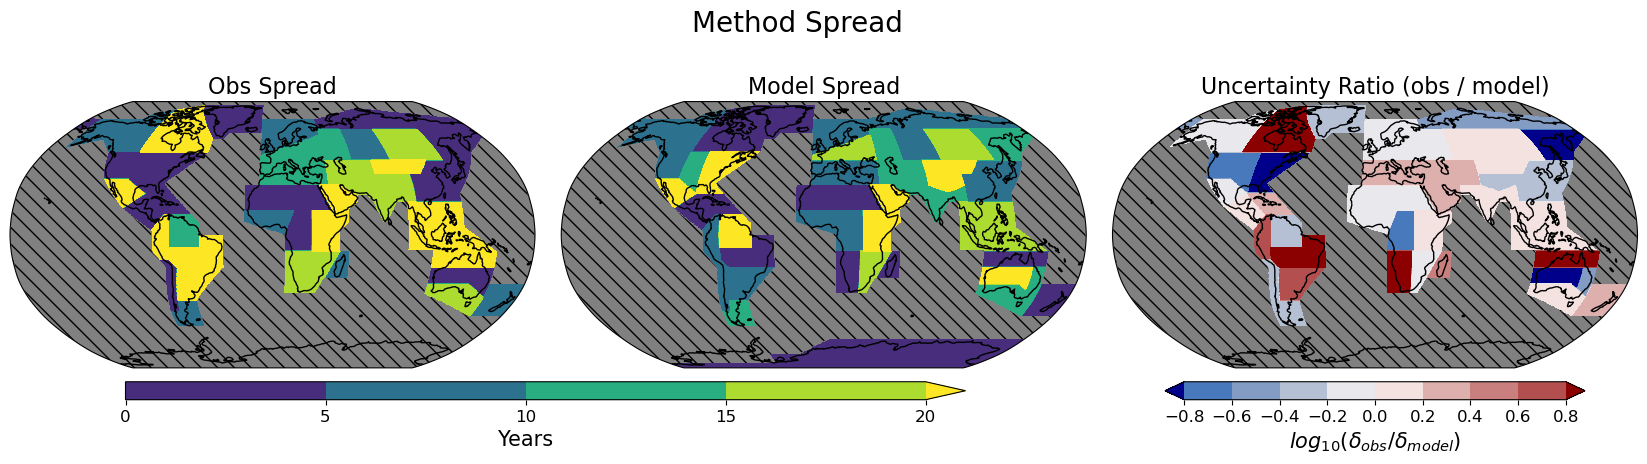

In [92]:
out_fig = plot_regional_spread(region_mean_obs_spread,region_mean_mod_spread,)

to_png(file=out_fig,filename='draft3_meanToE_spread_regionalmap',dpi=300,ext='pdf',bbox_inches='tight')

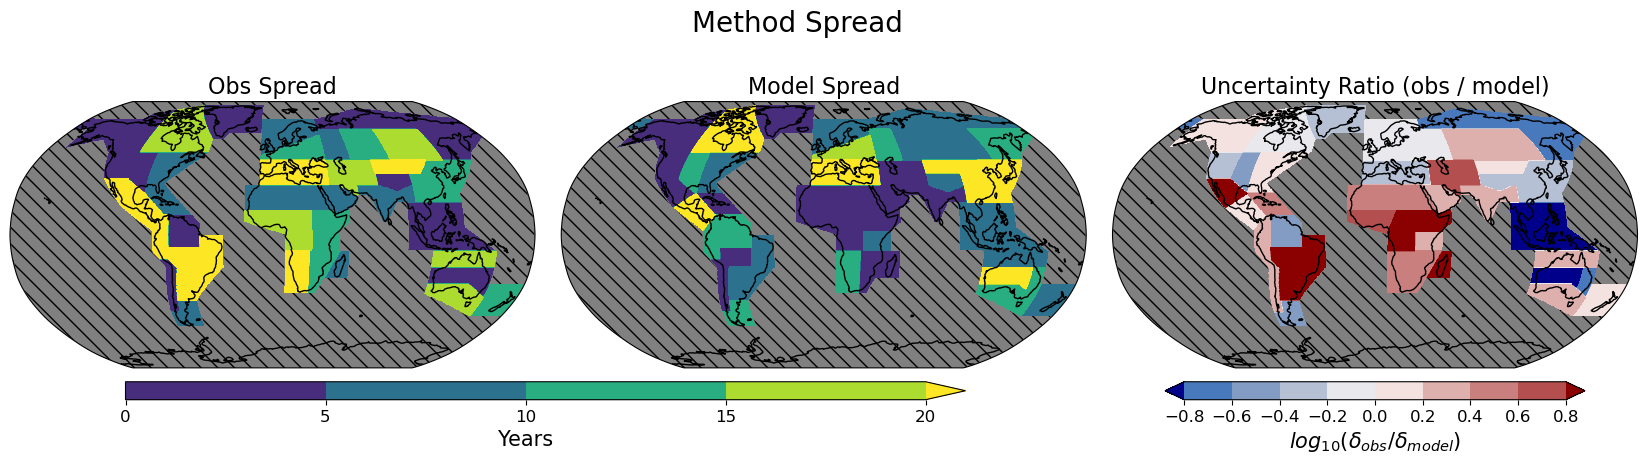

In [93]:
out_fig = plot_regional_spread(region_strict_obs_spread,region_strict_mod_spread,)

to_png(file=out_fig,filename='draft3_strictToE_spread_regionalmap',dpi=300,ext='pdf',bbox_inches='tight')

### With the total spread

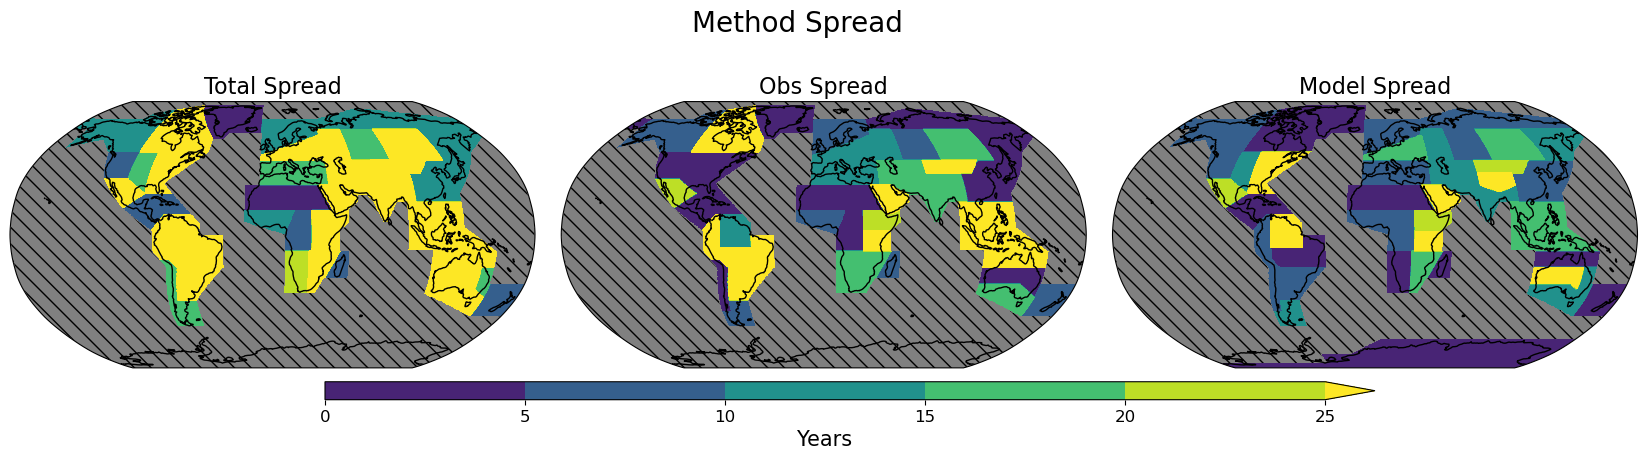

In [94]:
out_fig = plot_regional_spread3(
    region_mean_spread,
    region_mean_obs_spread,
    region_mean_mod_spread,
)

to_png(file=out_fig,filename='draft3_meanToE_spread_regionalmap',dpi=300,ext='pdf',bbox_inches='tight')

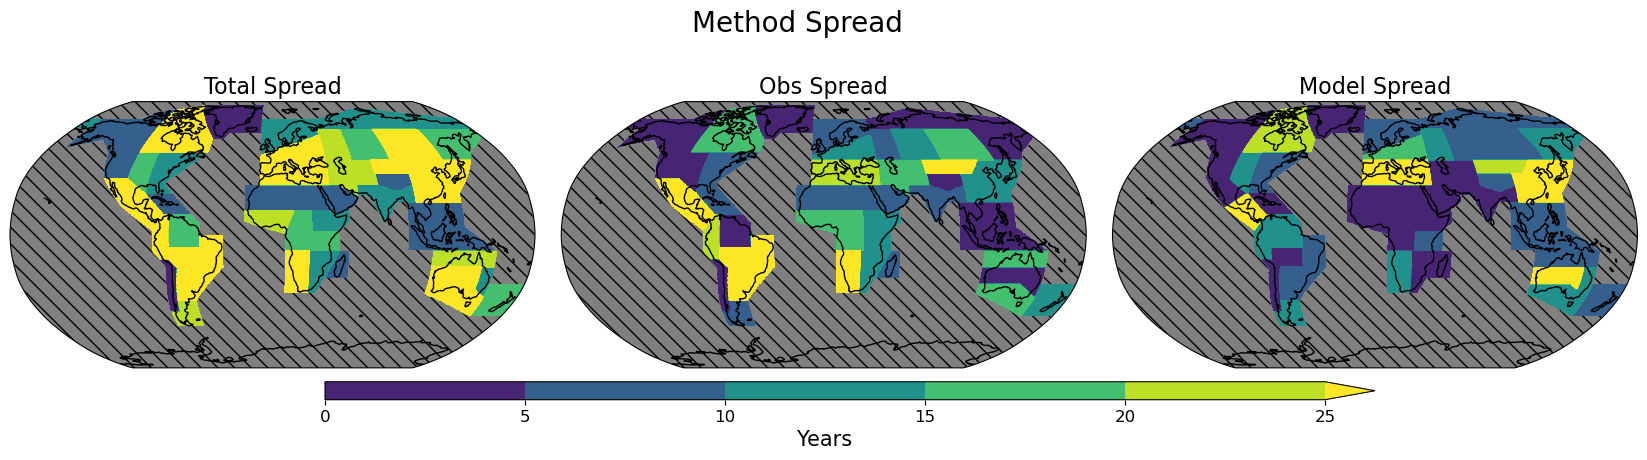

In [95]:
out_fig = plot_regional_spread3(
    region_strict_spread,
    region_strict_obs_spread,
    region_strict_mod_spread,
)

to_png(file=out_fig,filename='draft3_strictToE_spread_regionalmap',dpi=300,ext='pdf',bbox_inches='tight')

__This is not as useful as the spatial plots. The ratio panel is especially confusing, it mostly shows that observational uncertainty is relatively low over N.H. continents and Australia.__

Also the masking seems to be having an issue. Or zero values are being plotted wrong...  
^This is mostly fixed. I am calculating the model spread even if one observational product has no values, hence why there is zero spread for the strict emergence of E. Antarctica (only 2 of 8 values are not nan, but they are equal).

#### Spatial Data

In [16]:
def plot_spatial_spread(
    obs_spread,
    model_spread,
    title=True,
    surfacemask=None,
    surfacehatch="o",
    bool_pcolor=[True,True,False],
    spread_levels=np.linspace(0, 30, 7),
    delay_levels=np.linspace(-0.8,0.8,9),
):

    fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(21,6))
    axs = axs.flat

    cax1 = plt.axes([0.175, 0.22, 0.40, 0.03])
    cax2 = plt.axes([0.675, 0.22, 0.20, 0.03])

    ToE_cmap = copy.copy(mpl.cm.viridis)
    Toe_cmap = ListedColormap(sns.color_palette('viridis',n_colors=256))
    # ToE_cmap = copy.copy(mpl.cm.autumn_r)
    # ToE_cmap = copy.copy(mpl.cm.YlOrBr) # 
    
    delay_cmap = ListedColormap(sns.color_palette('vlag',n_colors=256))
    delay_cmap.set_over('darkred')
    delay_cmap.set_under('darkblue')
    
    spread_ratio  = np.log10(obs_spread/model_spread)

    masks  = [obs_spread,model_spread,spread_ratio]
    titles = ['Obs Spread','Model Spread','Spread Ratio (obs. / model)']
    levels = [spread_levels,spread_levels,delay_levels] 
    cmaps = [ToE_cmap,ToE_cmap,delay_cmap]
    extend = ['max','max','both']

    plt.subplots_adjust(wspace=0.05)
    
    ims = [] 
    for _ax,_mask,_label,_levels,_cmap,_pcolor,_extend in zip(axs,masks,titles,levels,cmaps,bool_pcolor,extend):
        if _pcolor:
            _norm = BoundaryNorm(_levels, ncolors=_cmap.N, clip=False,extend=_extend)
            im = _ax.pcolormesh(_mask.lon,_mask.lat,_mask,
                               transform=ccrs.PlateCarree(),
                               cmap=_cmap,
                               norm=_norm, 
                               )
        else:
            im = _ax.contourf(_mask.lon,_mask.lat,_mask,
                              transform=ccrs.PlateCarree(),
                              cmap=_cmap,
                              levels=_levels,
                              extend=_extend,
                             )

        _ = _ax.contourf(_mask.lon,_mask.lat,np.isnan(_mask),
                         transform=ccrs.PlateCarree(),
                         levels=[0,0.5,1.5],
                         extend='max',
                         colors=['none','gray'],
                         hatches=[None,'\\\\',],
                        )     

        _ax.coastlines()
        _ax.set_global()
        _ax.set_title(_label,fontsize=16)

        ims.append(im)

    for _ax in axs:
        if surfacemask is not None:
            _ = _ax.contourf(
                surfacemask.lon,
                surfacemask.lat,
                ~surfacemask,
                levels=[0,0.5,2],
                colors='none',
                transform=ccrs.PlateCarree(),
                hatches=[None, surfacehatch,],
                extend='max',
           )

    cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                         ticks=spread_levels,
                         cax=cax1,#label='Years',
                         extend='max',
                        )
    cbar1.set_label(label='Years',size=15,weight=None)

    cbar2 = fig.colorbar(ims[2],orientation='horizontal',
                         ticks=delay_levels,
                         cax=cax2,
                         extend='both',
                        )
    cbar2.set_label(label='$log_{10}(\delta_{obs} / \delta_{model}$)',size=15,weight=None)

    cbar1.ax.tick_params(labelsize=12) 
    cbar2.ax.tick_params(labelsize=12)

    fig.text(0.14, 0.68, "a.", fontsize=14)
    fig.text(0.40, 0.68, "b.", fontsize=14)
    fig.text(0.665, 0.68, "c.", fontsize=14)

    if title:
        fig.suptitle('Method Spread',fontsize=20,y=0.88)    

    return fig

<>:93: SyntaxWarning: invalid escape sequence '\d'
<>:93: SyntaxWarning: invalid escape sequence '\d'
/glade/derecho/scratch/jonahshaw/tmp/ipykernel_63210/2801399722.py:93: SyntaxWarning: invalid escape sequence '\d'
  cbar2.set_label(label='$log_{10}(\delta_{obs} / \delta_{model}$)',size=15,weight=None)


In [19]:
def plot_spatial_spread3(
    total_spread,
    obs_spread,
    model_spread,
    title=True,
    surfacemask=None,
    surfacehatch="o",
    countmask=None,
    counthatch="xx",
    spread_levels=np.linspace(0, 30, 7),
):
    fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(21,6))
    axs = axs.flat

    cax1 = plt.axes([0.275, 0.22, 0.50, 0.03])

    ToE_cmap = copy.copy(mpl.cm.viridis)
    Toe_cmap = ListedColormap(sns.color_palette('viridis',n_colors=256))
    # ToE_cmap = copy.copy(mpl.cm.autumn_r)
    # ToE_cmap = copy.copy(mpl.cm.YlOrBr) # 
        
    # spread_levels = np.linspace(0,30,7)

    masks  = [total_spread, obs_spread, model_spread]
    titles = ["Total Spread", 'Observation Spread','Model Spread']
    levels = [spread_levels, spread_levels, spread_levels] 
    cmaps = [ToE_cmap, ToE_cmap, ToE_cmap]
    extend = ['max','max','max']

    plt.subplots_adjust(wspace=0.05)
    
    ims = [] 
    for _ax,_mask,_label,_levels,_cmap,_extend in zip(axs,masks,titles,levels,cmaps,extend):
        _norm = BoundaryNorm(_levels, ncolors=_cmap.N, clip=False,extend=_extend)
        im = _ax.pcolormesh(_mask.lon,_mask.lat,_mask,
                           transform=ccrs.PlateCarree(),
                           cmap=_cmap,
                           norm=_norm, 
                           )

        _ = _ax.contourf(_mask.lon,_mask.lat,np.isnan(_mask),
                         transform=ccrs.PlateCarree(),
                         levels=[0,0.5,1.5],
                         extend='max',
                         colors=['none','gray'],
                        #  hatches=[None,'..',],
                        )     

        _ax.coastlines()
        _ax.set_global()
        _ax.set_title(_label,fontsize=16)

        ims.append(im)
        if countmask is not None:
            _ = _ax.contourf(
                countmask.lon,
                countmask.lat,
                (~countmask & surfacemask),
                levels=[0,0.5,2],
                transform=ccrs.PlateCarree(),
                colors=["none", "none"],
                hatches=[None, counthatch,],
                extend='max',
           )
    # for _ax in axs:
        if surfacemask is not None:
            _ = _ax.contourf(
                surfacemask.lon,
                surfacemask.lat,
                ~surfacemask,
                levels=[0,0.5,2],
                colors='none',
                transform=ccrs.PlateCarree(),
                hatches=[None, surfacehatch,],
                extend='max',
           )

    cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                         ticks=spread_levels,
                         cax=cax1,#label='Years',
                         extend='max',
                        )
    cbar1.set_label(label='Years',size=15,weight=None)
    cbar1.ax.tick_params(labelsize=12) 

    fig.text(0.14, 0.68, "a.", fontsize=14)
    fig.text(0.40, 0.68, "b.", fontsize=14)
    fig.text(0.665, 0.68, "c.", fontsize=14)

    if title:
        fig.suptitle('Method Spread',fontsize=20,y=0.88)    

    return fig

The white splotches are gridcells where the ratio actually becomes pretty even. I could do some more smoothing, but I'm not sure that's the right approach.

__Observational Uncertainty Dominates in the Tropics, Model Uncertainty dominates in the northern hemisphere. The Southern Ocean hasn't emerged so we don't assess spread there.__

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


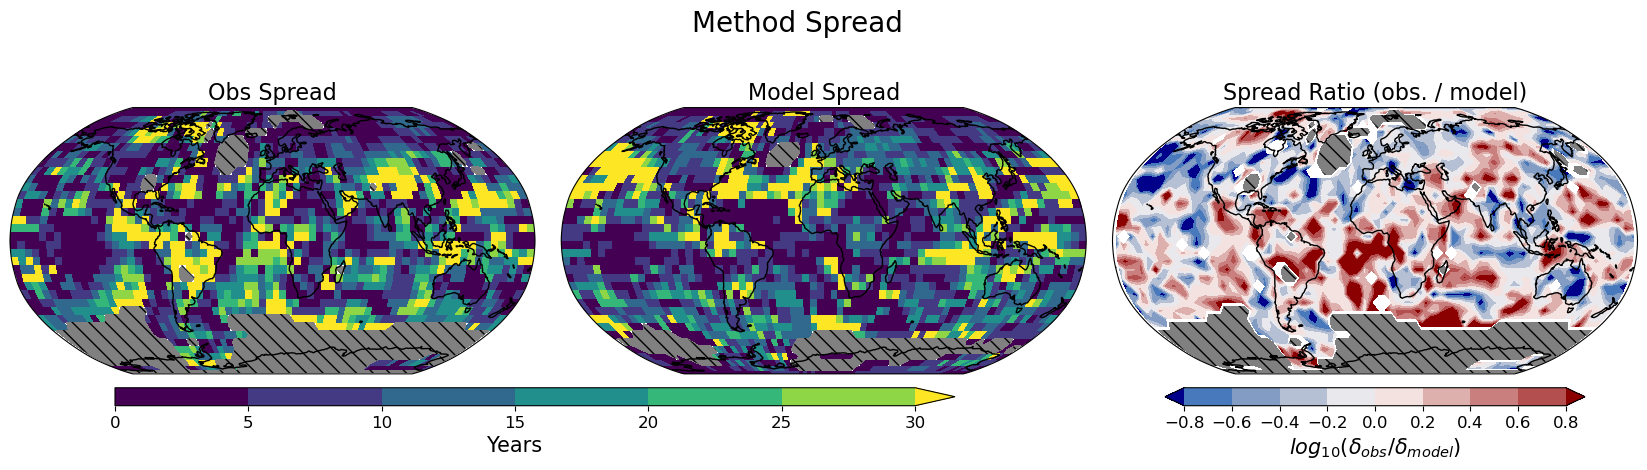

In [98]:
out_fig = plot_spatial_spread(spatial_mean_obs_spread,spatial_mean_mod_spread,bool_pcolor=[True,True,False])

to_png(file=out_fig,filename='draft2_meanToE_spread_spatialmap',dpi=300,ext='pdf',bbox_inches='tight')

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


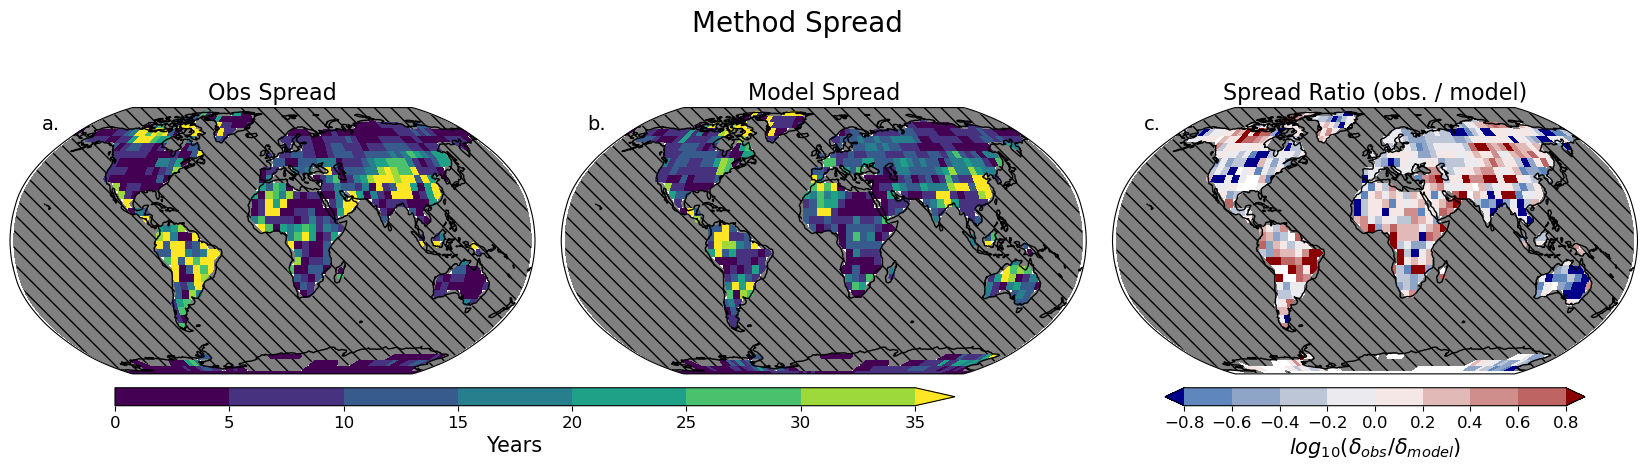

In [18]:
spatial_mean_obs_spread_land = spatial_mean_obs_spread.where(spatial_landmask)
spatial_mean_mod_spread_land = spatial_mean_mod_spread.where(spatial_landmask)

out_fig = plot_spatial_spread(
    spatial_mean_obs_spread_land,
    spatial_mean_mod_spread_land,
    bool_pcolor=[True, True, True],
    # bool_pcolor=[True, True, False],
    surfacemask=spatial_landmask,
    surfacehatch="..",
    spread_levels=np.linspace(0, 35, 8),
)

# to_png(file=out_fig,filename='draft3_meanToE_spread_spatialmap',dpi=300,ext='pdf',bbox_inches='tight')

In [ ]:
# region_mean_spread = region_mean_spread.where((~np.isnan(regional_toe_mean)).sum(dim=["model", "obs"]) >= count_threshold)
# region_strict_spread = region_strict_spread.where((~np.isnan(regional_toe_strict)).sum(dim=["model", "obs"]) >= count_threshold)

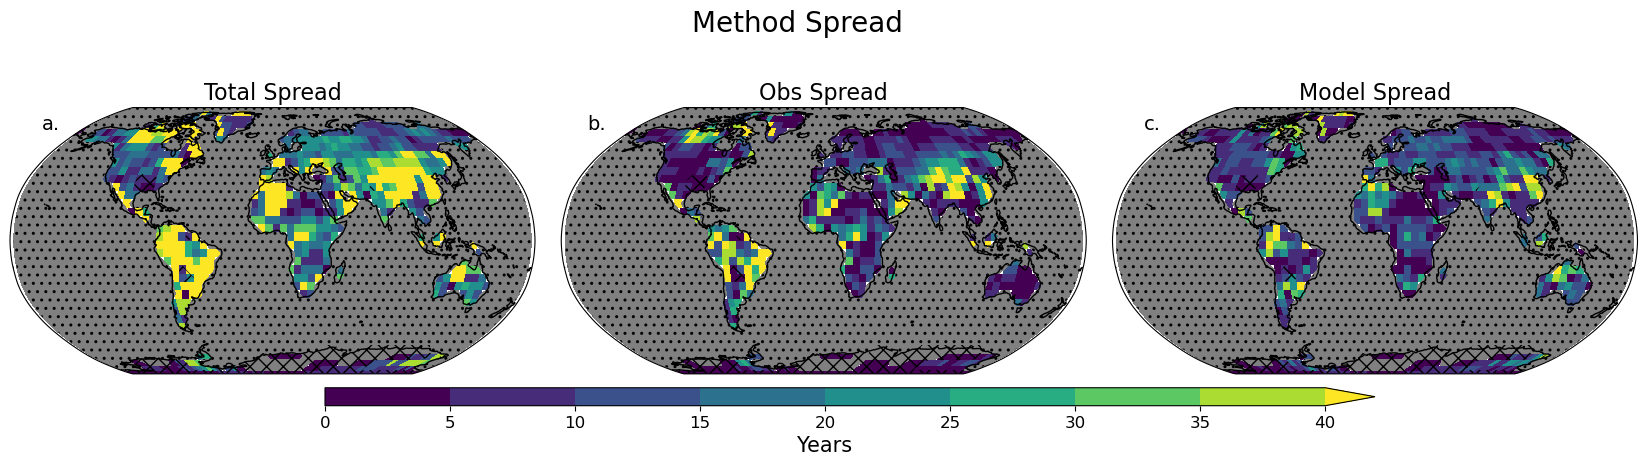

In [ ]:
spatial_mean_obs_spread_land = spatial_mean_obs_spread.where(spatial_landmask)
spatial_mean_mod_spread_land = spatial_mean_mod_spread.where(spatial_landmask)
spatial_mean_spread_land = spatial_mean_spread.where(spatial_landmask)

count_mask = (spatial_toe_mean.count(dim=["model", "obs"]) > 4)

out_fig = plot_spatial_spread3(
    spatial_mean_spread_land,
    spatial_mean_obs_spread_land,
    spatial_mean_mod_spread_land,
    # bool_pcolor=[True, True, False],
    surfacemask=spatial_landmask,
    surfacehatch="..",
    countmask=count_mask,
    spread_levels=np.linspace(0, 40, 9),
    title=False,
)

to_png(file=out_fig,filename='draft3_meanToE_spread_spatialmap_land',dpi=300,ext='pdf',bbox_inches='tight')

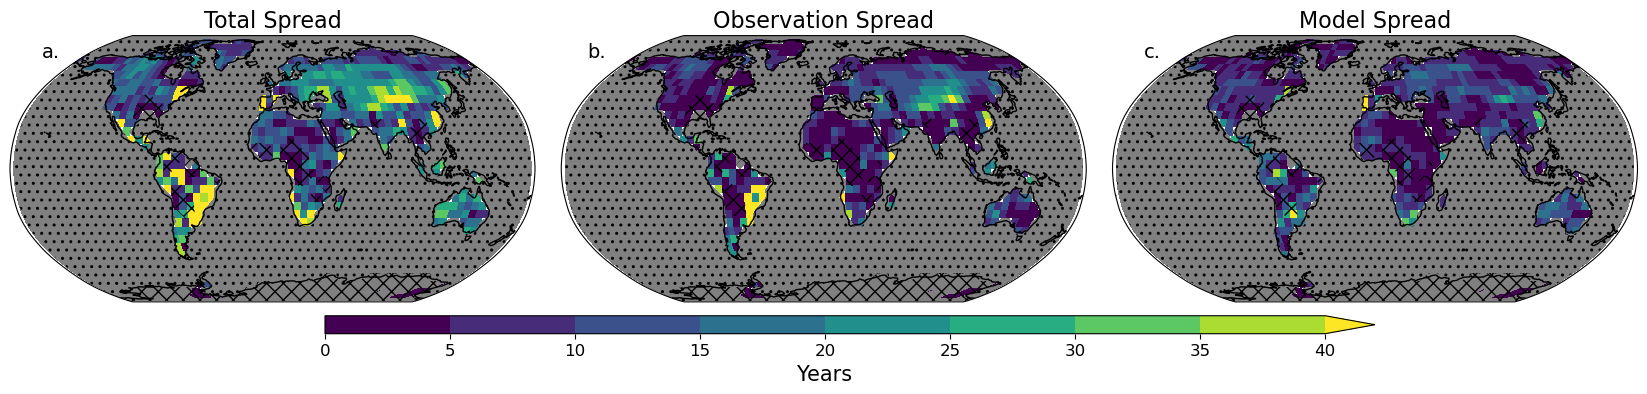

In [20]:
spatial_strict_obs_spread_land = spatial_strict_obs_spread.where(spatial_landmask)
spatial_strict_mod_spread_land = spatial_strict_mod_spread.where(spatial_landmask)
spatial_strict_spread_land = spatial_strict_spread.where(spatial_landmask)

count_mask = (spatial_toe_strict.count(dim=["model", "obs"]) > 4)

out_fig = plot_spatial_spread3(
    spatial_strict_spread_land,
    spatial_strict_obs_spread_land,
    spatial_strict_mod_spread_land,
    # bool_pcolor=[True, True, False],
    surfacemask=spatial_landmask,
    surfacehatch="..",
    countmask=count_mask,
    spread_levels=np.linspace(0, 40, 9),
    title=False,
)

to_png(file=out_fig,filename='draft3_strictToE_spread_spatialmap_land',dpi=300,ext='pdf',bbox_inches='tight')

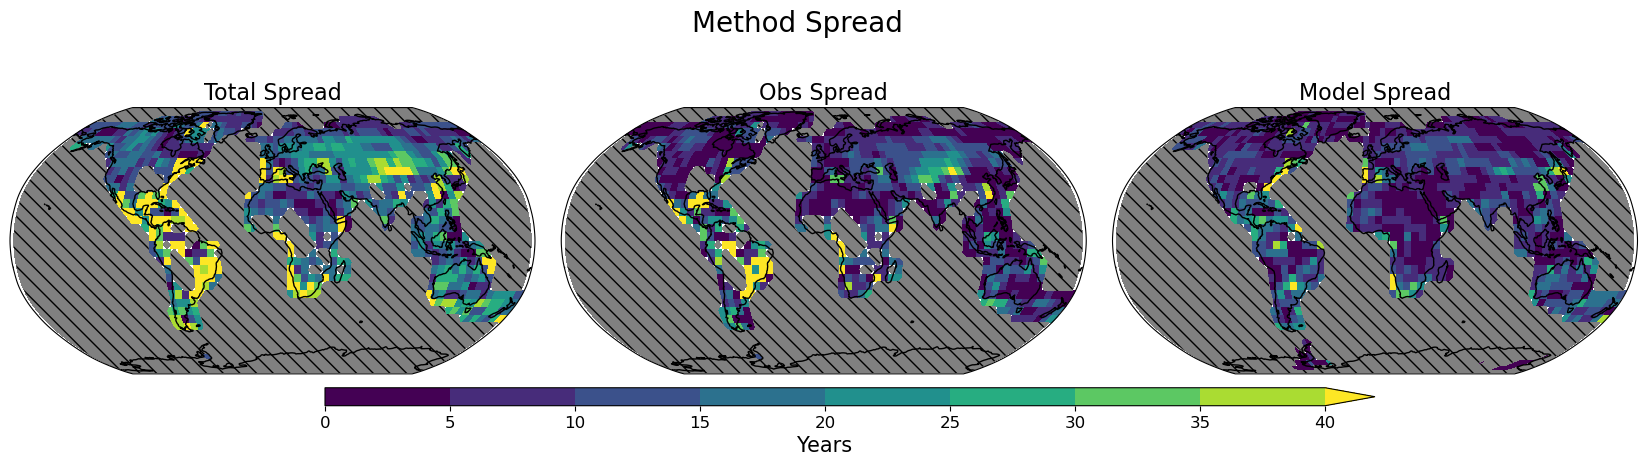

In [ ]:
spatial_strict_obs_spread_land = spatial_strict_obs_spread.where(spatial_landmask)
spatial_strict_mod_spread_land = spatial_strict_mod_spread.where(spatial_landmask)
spatial_strict_spread_land = spatial_strict_spread.where(spatial_landmask)

out_fig = plot_spatial_spread3(
    spatial_strict_spread_land,
    spatial_strict_obs_spread_land,
    spatial_strict_mod_spread_land,
    # bool_pcolor=[True, True, False],
    surfacemask=spatial_landmask,
    surfacehatch="..",
    spread_levels=np.linspace(0, 40, 9),
)

to_png(file=out_fig,filename='draft3_strictToE_spread_spatialmap_land',dpi=300,ext='pdf',bbox_inches='tight')

### But with the total spread and removing the ratio.

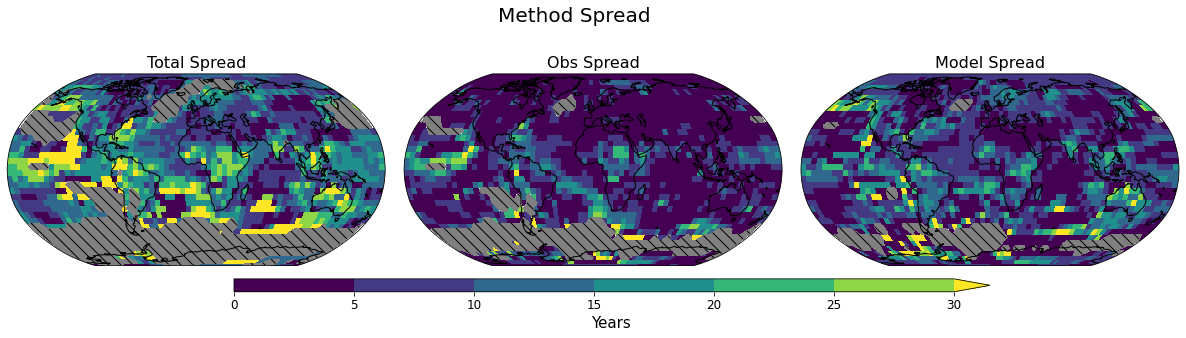

In [85]:
out_fig = plot_spatial_spread3(
    spatial_mean_spread,
    spatial_mean_obs_spread,
    spatial_mean_mod_spread,
)

to_png(file=out_fig,filename='draft3_meanToE_spread_spatialmap',dpi=300,ext='pdf',bbox_inches='tight')

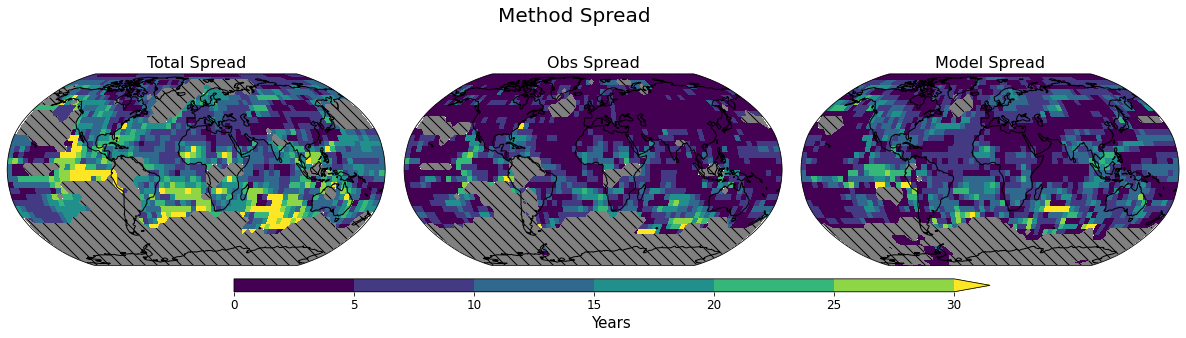

In [86]:
out_fig = plot_spatial_spread3(
    spatial_strict_spread,
    spatial_strict_obs_spread,
    spatial_strict_mod_spread,
)

to_png(file=out_fig,filename='draft3_strictToE_spread_spatialmap',dpi=300,ext='pdf',bbox_inches='tight')